# Important Files

## hpo.py and train.py

In [2]:
%%writefile hpo.py

# imports
import os
import sys
import logging

import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


# logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

# train function
def train(epochs, model, trainloader, optimizer, criterion, device):
    for i in range(epochs):
        model.train()
        train_loss = 0
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {i}: Train loss: {train_loss:.3f}")

# test function
def test(model, testloader):
    model.to("cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {correct}/{len(testloader.dataset)} ({100.0 * correct / len(testloader.dataset):.0f}%)")

# model class
class Net(nn.ModuleDict):
    def __init__(self):
        super(Net, self).__init__()
        #convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)
    
    def forward(self, x):
         # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = torch.flatten(x, 1)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
        

# data loader
def dataloaders(batch_size):
    transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor()
    ])
    
    trainset = datasets.MNIST("data", train=True, download=True, transform=transform)
    testset = datasets.MNIST("data", train=False, transform=transform)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size)
    
    return trainloader, testloader

# save model
def save(model, model_dir):
    path = os.path.join(model_dir, "model.pth")
    torch.save(model.cpu().state_dict(), path)

# main function
def main(args):
    # setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"DEVICE: {device}")
    
    # initialize model
    logger.info("INITIALIZE MODEL")
    model = Net()
    model.to(device)
    
    logger.info("CREATING DATA LOADERS")
    trainloader, testloader = dataloaders(args.batch_size)
    
    logger.info("INITIALIZE OPTIMIZER AND CRITERION")
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    logger.info("BEGIN TRAINING")
    train(args.epochs, model, trainloader, optimizer, criterion, device)
    
    logger.info("BEGIN TESTING")
    test(model, testloader)
    
    logger.info("SAVE MODEL WEIGHTS")
    save(model, args.model_dir)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="PyTorch MNIST HPO")
    parser.add_argument(
        "--batch-size", type=int, default=32, metavar="N", help="input batch size for both training and testing (default:32)",
    )
    parser.add_argument(
        "--epochs", type=int, default=10, metavar="N", help="number of epochs to train (default:10)",
    )
    parser.add_argument(
        "--lr", type=float, default=1.0, metavar="N", help="learning rate (default: 1.0)",
    )
    parser.add_argument(
        "--momentum", type=float, default=0.9, metavar="N", help="momentum for SDG optimizer (default: 0.9)",
    )
    # Container environment
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    
    # Parse
    args = parser.parse_args()
    main(args)

Writing hpo.py


## inference.py

Basic method.

In [3]:
%%writefile inference.py

import os
import sys
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

class Net(nn.ModuleDict):
    def __init__(self):
        super(Net, self).__init__()
        #convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)
    
    def forward(self, x):
         # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = torch.flatten(x, 1)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

# TODO: Add model_fn
def model_fn(model_dir):
    logger.info(f"MODEL DIR: {model_dir}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Net()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    model.to(device).eval()
    return model

Writing inference.py


## inference_v2.py

This one contains all the functions for querying an endpoint from a Lambda Function.

Resource: https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html

Sample Request: {"image_uri": "https://conx.readthedocs.io/en/latest/_images/MNIST_6_0.png"}

In [4]:
%%writefile inference_v2.py

import os
import sys
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from PIL import Image
import numpy as np

import requests
import json

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.ModuleDict):
    def __init__(self):
        super(Net, self).__init__()
        #convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)
    
    def forward(self, x):
         # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = torch.flatten(x, 1)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

# TODO: Add model_fn
def model_fn(model_dir):
    model = Net()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    model.to(device).eval()
    return model


def input_fn(request_body, request_content_type):
    assert request_content_type=='application/json'
    # expects a URI
    uri = json.loads(request_body)["image_uri"]
    logger.info(f"URI: {uri}")
    data = Image.open(requests.get(uri, stream=True).raw).convert('L')
    logger.info(f"DATA: {data}")
    # preprocess image
    transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
        ])
    data = transform(data).unsqueeze(0).to(device)
    logger.info(f"PREPROCESSED DATA: {data}")
    return data


def predict_fn(input_object, model):
    logger.info(f"PREPROCESSED INPUT DATA: {input_object}")
    with torch.no_grad():
        logger.info(f"MAKE PREDICTIONS")
        prediction = model(input_object)
    logger.info(f"PREDICTIONS: {prediction}")
    return prediction


def output_fn(predictions, content_type):
    logger.info(f"OUTPUT FORMATTER")
    assert content_type == 'application/json'
    res = np.argmax(predictions, 1).cpu().numpy().tolist()
    return json.dumps(res)

Writing inference_v2.py


## lambda_function.py

Lambda function using Boto3 for querying the endpoint using inference_v2.py file

In [5]:
%%writefile lambda_function.py

import json
import boto3


runtime = boto3.Session().client('sagemaker-runtime')
endpoint_name = 'mnist-endpoint'

def lambda_handler(event, context):
    print('Context:::', context)
    print('EventType::', type(event))
    
    response = runtime.invoke_endpoint(
        EndpointName = endpoint_name,
        ContentType = 'application/json',
        Accept = 'application/json',
        Body = json.dumps(event)
    )
    
    result = response['Body'].read().decode('utf-8')
    result = json.loads(result)
    
    return {
        'statusCode': 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'type-result':str(type(result)),
        'Content-Type-In':str(context),
        'body' : json.dumps(result),
        }

Writing lambda_function.py


# Imports

In [17]:
import sagemaker

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch, PyTorchModel

# Sagemaker Variables

In [18]:
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [19]:
print("Default Bucket: {}".format(bucket))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-250672895001
RoleArn: arn:aws:iam::250672895001:role/service-role/AmazonSageMaker-ExecutionRole-20230209T083631


# Hyperparameter Optimization

In [20]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(5, 10),
    "momentum": ContinuousParameter(0.5, 0.9), # Adding this since SDG is the optimization function chosen
}

In [21]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

In [28]:
# Estimator
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# Tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)

In [29]:
tuner.fit(wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................................................................................................................................!


In [32]:
# Get the best estimators with the best Hyperparameters
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-10 07:15:20 Starting - Found matching resource for reuse
2023-02-10 07:15:20 Downloading - Downloading input data
2023-02-10 07:15:20 Training - Training image download completed. Training in progress.
2023-02-10 07:15:20 Uploading - Uploading generated training model
2023-02-10 07:15:20 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '10',
 'lr': '0.01917874652567949',
 'momentum': '0.6984716955702364',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-10-06-50-26-699"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-250672895001/pytorch-training-2023-02-10-06-50-26-699/source/sourcedir.tar.gz"'}

# Training

In [35]:
best_hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()["batch-size"].replace('"', "")),
    "epochs": best_estimator.hyperparameters()["epochs"],
    "lr": best_estimator.hyperparameters()["lr"],
    "momentum": best_estimator.hyperparameters()["momentum"],
}

In [36]:
# Estimator
estimator = PyTorch(
    entry_point="train.py",
    framework_version="1.6", # using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=best_hyperparameters,
)    

In [37]:
estimator.fit(wait=True)

2023-02-10 07:27:45 Starting - Starting the training job...
2023-02-10 07:28:00 Starting - Preparing the instances for trainingProfilerReport-1676014064: InProgress
......
2023-02-10 07:29:11 Downloading - Downloading input data...
2023-02-10 07:29:41 Training - Downloading the training image......
2023-02-10 07:30:31 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-10 07:30:26,941 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-10 07:30:26,944 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-10 07:30:26,954 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-10 07:30:26,957 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-10 07:30:27,122 sagemaker-training-toolkit INFO     No GP

# Deployment

In [73]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-250672895001/pytorch-training-2023-02-10-07-27-44-685/output/model.tar.gz


In [83]:
# TODO: Add Model Loader
model = PyTorchModel(
    entry_point="inference.py",
    role=role,
    model_data=model_data,
    framework_version="1.8",
    py_version="py36",
)

# TODO: Deploy
predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

---------!

In [118]:
# Method 2
model_v2 = PyTorchModel(
    entry_point="inference_v2.py",
    role=role,
    model_data=model_data,
    framework_version="1.8",
    py_version="py36",
)

# TODO: Deploy
predictor_v2 = model_v2.deploy(initial_instance_count=1, instance_type="ml.t2.medium", endpoint_name="mnist-endpoint")

----------!

# Testing

Utilizes endpoint from inference.py

In [75]:
# installing these as they'll be needed for inference
!pip3 install torch torchvision --no-cache-dir

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [41]:
# Run an prediction on the endpoint
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [84]:
# TODO: Predict function that takes in an image, preprocesses it, and uses the endpoint for prediction
def predict(image_path):
    image = Image.open(image_path).convert('L')

    transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
        ])

    preprocessed_image = transform(image).unsqueeze(0)
    preprocessed_image = preprocessed_image.to("cpu")

    response = predictor.predict(preprocessed_image)
    pred = np.argmax(response, 1)
    plt.imshow(Image.open(image_path))
    plt.show()
    print(f"Actual: {image_path[:2]}, Prediction: {pred[0]}")

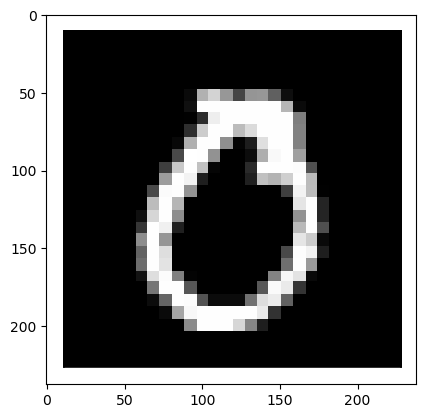

Actual: 0., Prediction: 0


In [85]:
# TODO: Test prediction
predict("0.webp")

# Cleanup

In [86]:
# TODO: Delete endpoint
predictor.delete_endpoint()

In [117]:
predictor_v2.delete_endpoint()